# Model Output Analysis

```bash
# create "finalized_model_{ts}.sav" within the model folder
python3 train_model data model

# do this 9 more times
for i in {1..9}; do python3 train_model.py data model; done
```

In [7]:
import os
import csv
import json
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import joblib
import xgboost
from sklearn.metrics import plot_confusion_matrix, f1_score
from tqdm import tqdm_notebook

from util.elapsed_timer import ElapsedTimer
from util.evaluate_12ECG_score import load_table, load_weights
from train_12ECG_classifier import _get_fieldnames

In [8]:
import importlib
importlib.reload(torch)
print("CUDA", torch.cuda.is_available())
importlib.reload(xgboost)
print(xgboost.__version__)

CUDA False


<module 'xgboost' from '/home/alexwong/miniconda3/envs/msc_research/lib/python3.6/site-packages/xgboost/__init__.py'>

In [9]:
# Load the SNOMED_CT Mapping to DX
with open("data/snomed_ct_dx_map.json", "r") as f:
    SNOMED_CODE_MAP = json.load(f)

# Load the scored labels and weights
rows, _cols, _vals = load_table("evaluation-2020/weights.csv10
scored_codes = [int(r) for r in rows]


In [10]:
# output_folder = "mrr_model"
# output_folder = "mean_model" # best, submission
output_folder = "paper_models" # generated importances

In [11]:
try:
    data_cache
except NameError:
    print("Loading features csv file...")
    with ElapsedTimer() as t:
        with open(os.path.join(output_folder, "features.csv"), "r") as f:
            reader = csv.reader(f)
            header = next(reader)

        # load the cached ECG record features
        data_cache_fp = os.path.join(output_folder, "features.csv")
        data_cache = pd.read_csv(data_cache_fp, header=0, names=header, index_col="header_file")

    print(f"Took {t.duration} seconds")
# convert the structured array into unstructured arrays
# to_features = [n for n in data_cache.dtype.names if n not in ("dx", "record_name", "seq_len")]
# with open("model/features.csv", "r") as f:
#     reader = csv.DictReader(f, fieldnames=_get_fieldnames())
#     header = next(reader)


Loading features csv file...
Took 555.6031433157623 seconds


In [12]:
label_cache = {}
with open(os.path.join(output_folder, "dxs.txt"), mode="r", newline="\n") as labelfile:
    for line in labelfile.readlines():
        header_file_path, dxs = json.loads(line)
        label_cache[header_file_path] = dxs

- complete right bundle branch block (code 713427006), covered by right bundle branch block (code 59118001)
- premature atrial contraction (code 284470004), covered by supraventricular premature beats (code 63593006)
- premature ventricular contractions (code 427172004), covered by ventricular ectopic beats (code 17338001)


In [13]:
# what features are we using?
for idx, field_name in enumerate(header[1:]):
    print(f"f{idx:<3}: {field_name}")

f0  : age
f1  : sex
f2  : I_ECG_Rate_Mean
f3  : I_HRV_RMSSD
f4  : I_HRV_MeanNN
f5  : I_HRV_SDNN
f6  : I_HRV_SDSD
f7  : I_HRV_CVNN
f8  : I_HRV_CVSD
f9  : I_HRV_MedianNN
f10 : I_HRV_MadNN
f11 : I_HRV_MCVNN
f12 : I_HRV_IQRNN
f13 : I_HRV_pNN50
f14 : I_HRV_pNN20
f15 : I_HRV_TINN
f16 : I_HRV_HTI
f17 : I_HRV_ULF
f18 : I_HRV_VLF
f19 : I_HRV_LF
f20 : I_HRV_HF
f21 : I_HRV_VHF
f22 : I_HRV_LFHF
f23 : I_HRV_LFn
f24 : I_HRV_HFn
f25 : I_HRV_LnHF
f26 : I_HRV_SD1
f27 : I_HRV_SD2
f28 : I_HRV_SD1SD2
f29 : I_HRV_S
f30 : I_HRV_CSI
f31 : I_HRV_CVI
f32 : I_HRV_CSI_Modified
f33 : I_HRV_PIP
f34 : I_HRV_IALS
f35 : I_HRV_PSS
f36 : I_HRV_PAS
f37 : I_HRV_GI
f38 : I_HRV_SI
f39 : I_HRV_AI
f40 : I_HRV_PI
f41 : I_HRV_C1d
f42 : I_HRV_C1a
f43 : I_HRV_SD1d
f44 : I_HRV_SD1a
f45 : I_HRV_C2d
f46 : I_HRV_C2a
f47 : I_HRV_SD2d
f48 : I_HRV_SD2a
f49 : I_HRV_Cd
f50 : I_HRV_Ca
f51 : I_HRV_SDNNd
f52 : I_HRV_SDNNa
f53 : I_HRV_ApEn
f54 : I_HRV_SampEn
f55 : I_hb__abs_energy
f56 : I_hb__absolute_sum_of_changes
f57 : I_hb__agg_autocorre

# Experiment Specific Outputs

In [14]:
# load the experiment save files

# Using only "dx" value (weight=1.0)
experiment_fps = tuple(sorted(glob(os.path.join(output_folder, "finalized_model_*.sav"))))

experiment_fps = [exp_fp for exp_fp in experiment_fps if "imp" not in exp_fp][-100:]

print(experiment_fps)

print(len(experiment_fps))
# no label rebalancing
# original: finalized_model_1594761951.sav to finalized_model_1594766304.sav, or first 100

['paper_models/finalized_model_1596697134.sav', 'paper_models/finalized_model_1596703703.sav', 'paper_models/finalized_model_1596710087.sav', 'paper_models/finalized_model_1596716525.sav', 'paper_models/finalized_model_1596723012.sav', 'paper_models/finalized_model_1596729282.sav', 'paper_models/finalized_model_1596735892.sav', 'paper_models/finalized_model_1596742020.sav', 'paper_models/finalized_model_1596748541.sav', 'paper_models/finalized_model_1596754719.sav', 'paper_models/finalized_model_1596760986.sav', 'paper_models/finalized_model_1596767382.sav', 'paper_models/finalized_model_1596773362.sav', 'paper_models/finalized_model_1596779758.sav', 'paper_models/finalized_model_1596786182.sav', 'paper_models/finalized_model_1596792206.sav', 'paper_models/finalized_model_1596798583.sav', 'paper_models/finalized_model_1596805005.sav', 'paper_models/finalized_model_1596811151.sav', 'paper_models/finalized_model_1596817740.sav', 'paper_models/finalized_model_1596823920.sav', 'paper_model

# Challenge Relevant Scores
Show the challenge reported scores on the evaluation set

In [15]:
challenge_summary_outputs = {}

# with tqdm_notebook(experiment_fps) as t:
for idx, experiment_fp in enumerate(experiment_fps):
    with ElapsedTimer() as t:
        print(f"{idx} / {len(experiment_fps)}: {experiment_fp} results...")
        experiment = joblib.load(experiment_fp)

        for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
              'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
            cso = challenge_summary_outputs.get(k, [])
            cso.append(experiment[k])
            challenge_summary_outputs[k] = cso
    print(f"\tTook {t.duration} seconds")

paper_models/finalized_model_1596697134.sav results...
Took 2.421135500073433 seconds
paper_models/finalized_model_1596703703.sav results...
Took 1.8337401505559683 seconds
paper_models/finalized_model_1596710087.sav results...
Took 1.757328676059842 seconds
paper_models/finalized_model_1596716525.sav results...
Took 1.817987933754921 seconds
paper_models/finalized_model_1596723012.sav results...
Took 1.8163847774267197 seconds
paper_models/finalized_model_1596729282.sav results...
Took 1.7749476972967386 seconds
paper_models/finalized_model_1596735892.sav results...
Took 1.7865745481103659 seconds
paper_models/finalized_model_1596742020.sav results...
Took 1.7649416644126177 seconds
paper_models/finalized_model_1596748541.sav results...
Took 1.7798709478229284 seconds
paper_models/finalized_model_1596754719.sav results...
Took 1.7745920065790415 seconds
paper_models/finalized_model_1596760986.sav results...
Took 1.777436399832368 seconds
paper_models/finalized_model_1596767382.sav res

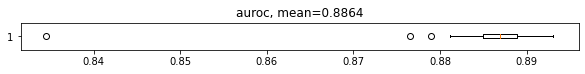

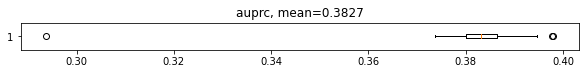

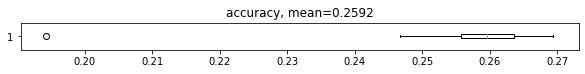

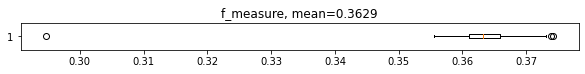

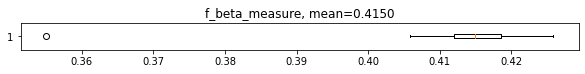

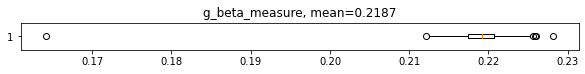

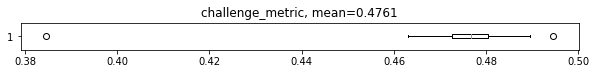

auroc
	DescribeResult(nobs=100, minmax=(0.8345052097333201, 0.89306021432292), mean=0.886385411287805, variance=3.6582587586685474e-05, skewness=-6.388815833020768, kurtosis=52.451883472529666)
auprc
	DescribeResult(nobs=100, minmax=(0.2937169447202192, 0.39799974416208467), mean=0.38265101923914663, variance=0.00010648387778448368, skewness=-6.376172014810823, kurtosis=53.506471938215334)
accuracy
	DescribeResult(nobs=100, minmax=(0.1942325297528227, 0.26940921744509744), mean=0.2591724521147259, variance=6.936111351848487e-05, skewness=-4.752216321557725, kurtosis=35.05684512368257)
f_measure
	DescribeResult(nobs=100, minmax=(0.2947004936151157, 0.3742202402737842), mean=0.3628743190927369, variance=6.260838018848213e-05, skewness=-6.369022712093998, kurtosis=53.44624464879596)
f_beta_measure
	DescribeResult(nobs=100, minmax=(0.35500899075982667, 0.4258492956588402), mean=0.41495774637154975, variance=5.777492779700153e-05, skewness=-4.837052882431188, kurtosis=36.846811246578305)
g_

In [16]:
all_desc_stats = {}
for k, v in challenge_summary_outputs.items():
    fig1, ax1 = plt.subplots(figsize=(10, 0.5))
    desc_stats = sp.stats.describe(v)
    all_desc_stats[k] = desc_stats
    ax1.set_title(f"{k}, mean={desc_stats.mean:.4f}")
    ax1.boxplot(v, vert=False)
    plt.show()

for k, v in all_desc_stats.items():
    print(f"{k}\n\t{v}")

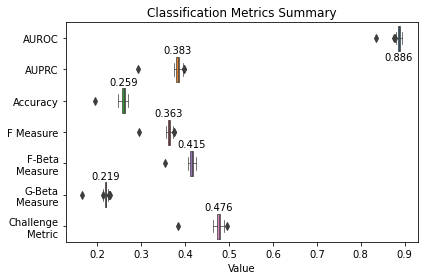

In [92]:
# print(challenge_summary_outputs)
box_plot_dict = {"Metric": [], "Value": []}
for k, v in challenge_summary_outputs.items():
    if k == "auroc":
        k_disp = "AUROC"
    elif k == "auprc":
        k_disp = "AUPRC"
    elif k == "accuracy":
        k_disp = "Accuracy"
    elif k == "f_measure":
        k_disp = "F Measure"
    elif k == "f_beta_measure":
        k_disp = "F-Beta\nMeasure"
    elif k == "g_beta_measure":
        k_disp = "G-Beta\nMeasure"
    elif k == "challenge_metric":
        k_disp = "Challenge\nMetric"
    box_plot_dict["Metric"] += [k_disp, ] * len(v)
    box_plot_dict["Value"] += v

bp_df = pd.DataFrame(box_plot_dict)
ax = sns.boxplot(
    y="Metric", x="Value", data=bp_df, linewidth=0.7
)
mean = bp_df.groupby(["Metric"])["Value"].mean()

# print(medians)

# medians
metric_ref = ["AUROC", "AUPRC", "Accuracy", "F Measure", "F-Beta\nMeasure", "G-Beta\nMeasure", "Challenge\nMetric"]

for ytick in ax.get_yticklabels():
    ytick_name = ytick.get_text()
    val_output = f"{mean[ytick_name]:.3f}"
    x_offset = mean[ytick_name]
    if mean[ytick_name] > 0.5:
        ha = "center"
        x_offset -= 0
    else:
        ha = "center"
        x_offset += 0
    y_offset = metric_ref.index(ytick_name)
    if metric_ref.index(ytick_name) >= 1:
        y_offset -= 0.6
    else:
        y_offset += 0.6
    ax.annotate(
        val_output,
        xy=(mean[ytick_name], metric_ref.index(ytick_name)),
        xytext=(x_offset, y_offset),
#         arrowprops={"arrowstyle": "-"},
        horizontalalignment=ha,
        verticalalignment="center"
    )
# print(dir(ax))
ax.set_ylabel("")
ax.set_title("Classification Metrics Summary")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "classification_metrics.png"), bbox_inches="tight", dpi=300)
plt.show()


In [93]:
# print(box_plot_dict)
with open(os.path.join(output_folder, "box_plot_dict.json"), "w") as f:
    json.dump(box_plot_dict, f)


### Phase 1 and 2 plot, addressing Sunil's comments

In [94]:
def phase_1_2_gen_df():
    experiment_fps_phase2 = tuple(sorted(glob(os.path.join(output_folder, "finalized_model_*_feat_1000.sav"))))
    print(len(experiment_fps_phase2))

    challenge_summary_outputs = {}

    # with tqdm_notebook(experiment_fps) as t:
    for idx, experiment_fp in enumerate(experiment_fps_phase2):
        with ElapsedTimer() as t:
            experiment = joblib.load(experiment_fp)

            for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
                  'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
                cso = challenge_summary_outputs.get(k, [])
                cso.append(experiment[k])
                challenge_summary_outputs[k] = cso
        print(f"{idx}/{len(experiment_fps_phase2)}: {experiment_fp} results... took {t.duration} seconds")

    box_plot_dict = {"Metric": [], "Value": [], "Version": []}
    for k, v in challenge_summary_outputs.items():
        if k == "auroc":
            k_disp = "AUROC"
        elif k == "auprc":
            k_disp = "AUPRC"
        elif k == "accuracy":
            k_disp = "Accuracy"
        elif k == "f_measure":
            k_disp = "F Measure"
        elif k == "f_beta_measure":
            k_disp = "F-Beta\nMeasure"
        elif k == "g_beta_measure":
            k_disp = "G-Beta\nMeasure"
        elif k == "challenge_metric":
            k_disp = "Challenge\nMetric"
        box_plot_dict["Metric"] += [k_disp, ] * len(v)
        box_plot_dict["Value"] += v
        box_plot_dict["Version"] += ["Phase 2"] * len(v)

    return pd.DataFrame(box_plot_dict)

phase_2_df = phase_1_2_gen_df()
phase_2_df

100
0/100: paper_models/finalized_model_1599321123_feat_1000.sav results... took 0.3427698314189911 seconds
1/100: paper_models/finalized_model_1599321329_feat_1000.sav results... took 0.28952292166650295 seconds
2/100: paper_models/finalized_model_1599321536_feat_1000.sav results... took 0.2733442597091198 seconds
3/100: paper_models/finalized_model_1599321741_feat_1000.sav results... took 0.3229192402213812 seconds
4/100: paper_models/finalized_model_1599321949_feat_1000.sav results... took 0.274098165333271 seconds
5/100: paper_models/finalized_model_1599322153_feat_1000.sav results... took 0.275672921910882 seconds
6/100: paper_models/finalized_model_1599322362_feat_1000.sav results... took 0.2837696373462677 seconds
7/100: paper_models/finalized_model_1599322569_feat_1000.sav results... took 0.26514450274407864 seconds
8/100: paper_models/finalized_model_1599322776_feat_1000.sav results... took 0.29160078056156635 seconds
9/100: paper_models/finalized_model_1599322986_feat_1000.sa

,Metric,Value,Version
0,AUROC,0.892947,Phase 2
1,AUROC,0.887546,Phase 2
2,AUROC,0.888970,Phase 2
3,AUROC,0.896356,Phase 2
4,AUROC,0.890468,Phase 2
...,...,...,...
695,Challenge\nMetric,0.486379,Phase 2
696,Challenge\nMetric,0.484944,Phase 2
697,Challenge\nMetric,0.488076,Phase 2
698,Challenge\nMetric,0.491978,Phase 2


<a list of 7 Text major ticklabel objects>
0.8345052097333201
0.8810233809392537
0.39799974416208467
0.40275213232558255
0.26940921744509744
0.26616145994432416
0.3742202402737842
0.3782702085828715
0.4258492956588402
0.4378159935607236
0.22817348685945363
0.23055033274236214
0.4945281990314718
0.5004995903390557


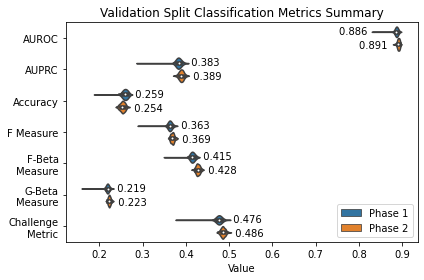

In [95]:
phase_1_df = bp_df
phase_1_df["Version"] = ["Phase 1"] * len(phase_1_df)
phase_1_2_df = pd.concat([phase_1_df, phase_2_df])

ax = sns.violinplot(y="Metric", x="Value", hue="Version", data=phase_1_2_df)
# ax = sns.boxplot(y="Metric", x="Value", hue="Version", data=phase_1_2_df)

group_phase_1 = phase_1_df.groupby(["Metric"])["Value"]
group_phase_2 = phase_2_df.groupby(["Metric"])["Value"]

print(ax.get_yticklabels())

for ytick in ax.get_yticklabels():
    ytick_name = ytick.get_text()
    
    # Phase 1
    val_output = f"{group_phase_1.mean()[ytick_name]:.3f}"
#     x_offset = mean[ytick_name]
    if ytick_name == "AUROC":
        val_output = f"{val_output}  "
        x_offset = group_phase_1.min()[ytick_name]
        ha="right"
    else:
        val_output = f"  {val_output}"
        x_offset = group_phase_1.max()[ytick_name]
        ha="left"
    print(x_offset)

    y_offset = metric_ref.index(ytick_name)
#     if metric_ref.index(ytick_name) >= 1:
#     y_offset -= 0.6
#     else:
    y_offset -= 0.225
    ax.annotate(
        val_output,
        xy=(mean[ytick_name], metric_ref.index(ytick_name)),
        xytext=(x_offset, y_offset),
#         arrowprops={"arrowstyle": "-"},
        horizontalalignment=ha,
        verticalalignment="center"
    )

    # Phase 2
    val_output = f"{group_phase_2.mean()[ytick_name]:.3f}"
#     x_offset = mean[ytick_name]
    if ytick_name == "AUROC":
        val_output = f"{val_output}  "
        x_offset = group_phase_2.min()[ytick_name]
        ha="right"
    else:
        val_output = f"  {val_output}"
        x_offset = group_phase_2.max()[ytick_name]
        ha="left"
    print(x_offset)

    y_offset = metric_ref.index(ytick_name)
#     if metric_ref.index(ytick_name) >= 1:
#     y_offset -= 0.6
#     else:
    y_offset += 0.225
    ax.annotate(
        val_output,
        xy=(mean[ytick_name], metric_ref.index(ytick_name)),
        xytext=(x_offset, y_offset),
#         arrowprops={"arrowstyle": "-"},
        horizontalalignment=ha,
        verticalalignment="center"
    )
    
ax.legend(loc="lower right")
ax.set_title("Validation Split Classification Metrics Summary")
ax.set_ylabel("")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "classification_metrics_phase_1_2.png"), bbox_inches="tight", dpi=300)
plt.show()


# Confusion Matrix

In [96]:
def plot_experiment_confusion_matrices(experiment_fp):
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    # get the evaluation records
    
    raw_dx_evals = []

#     for (record_name, dc_row) in data_cache.iterrows():
#         if record_name in eval_records:
#             raw_data_eval = dc_row.to_numpy()

#             raw_data_evals.append(raw_data_eval)
#             raw_dx_evals.append(label_cache[record_name])
#     data_evals = np.stack(raw_data_evals)

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        _abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        # hardcoded duplicate classifiers based on label scoring weights
        dsc = None
        if sc == 713427006:
            # A: 713427006 and 59118001
            dsc = 59118001
        elif sc == 284470004:
            # B: 284470004 and 63593006
            dsc = 63593006
        elif sc == 427172004:
            # C: 427172004 and 17338001
            dsc = 17338001

        if dsc is not None:
            _, ddx = SNOMED_CODE_MAP[str(dsc)]
            print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
            continue

        print(f"Classifier evaluation results for {dx} (code {sc})...")

        isc = None
        if sc == 59118001:
            isc = 713427006
        elif sc == 63593006:
            isc = 284470004
        elif sc == 17338001:
            isc = 427172004
        
        if isc is not None:
            _, idx = SNOMED_CODE_MAP[str(isc)]
            print(f"\tIncluding {idx} (code {isc})")

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        xgb_params = model.get_xgb_params()
        disp_params = {**xgb_params, 'monotone_constraints': None}
        print(disp_params)
        # print(f"scale_pos_weight: {xgb_params['scale_pos_weight']:.4f}")

        #fig, axs = plt.subplots(nrows=1, ncols=2)
        fig = plt.figure(constrained_layout=True, figsize=(14, 4))
        fig.suptitle(dx, x=0, y=1, horizontalalignment="left", fontsize=20)
        gs = fig.add_gridspec(1, 3)
        ax0 = fig.add_subplot(gs[0, 0])
        ax0.set_title("Evaluation")
        ax1 = fig.add_subplot(gs[0, 1:])
        
        # normalize must be one of {'true', 'pred', 'all', None}
        disp = plot_confusion_matrix(
            model, data_evals, eval_labels, normalize=None, ax=ax0,
        )
        # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance
        importance_type = "weight" # weight, gain, cover
        importance_title = f"Feature Importance by {importance_type}"
        ax = xgboost.plot_importance(
            model, height=0.2, max_num_features=15, ax=ax1,
            title=importance_title, importance_type=importance_type)
        plt.show()


In [97]:
# plot_experiment_confusion_matrices(experiment_fps[1])
# plot_experiment_confusion_matrices(experiment_fps[1])  # so on...

# F1-Scores across all experiments

In [98]:

f1_box_plot_data = {}

experiment_fps_phase2 = tuple(sorted(glob(os.path.join(output_folder, "finalized_model_*_feat_1000.sav"))))


# for experiment_fp in experiment_fps:
for experiment_fp in experiment_fps_phase2:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")
    
    raw_dx_evals = []

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]

#         # hardcoded duplicate classifiers based on label scoring weights
#         dsc = None
#         if sc == 713427006:
#             # A: 713427006 and 59118001
#             dsc = 59118001
#         elif sc == 284470004:
#             # B: 284470004 and 63593006
#             dsc = 63593006
#         elif sc == 427172004:
#             # C: 427172004 and 17338001
#             dsc = 17338001

#         if dsc is not None:
#             #_, ddx = SNOMED_CODE_MAP[str(dsc)]
#             #print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
#             continue

        isc = None
#         if sc == 59118001:
#             isc = 713427006
#         elif sc == 63593006:
#             isc = 284470004
#         elif sc == 17338001:
#             isc = 427172004
        
#         if isc is not None:
#             _, idx = SNOMED_CODE_MAP[str(isc)]

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        
        # normalize must be one of {'true', 'pred', 'all', None}
        pred = model.predict(data_evals[model.get_booster().feature_names])
        f1 = f1_score(eval_labels, pred)
        # print(f"\t{dx} ({abbrv}) (code {sc}) F1_Score:", f1)

        f1_box_plot_data[abbrv] = f1_box_plot_data.get(abbrv, []) + [f1,]



paper_models/finalized_model_1599321123_feat_1000.sav results...
paper_models/finalized_model_1599321329_feat_1000.sav results...
paper_models/finalized_model_1599321536_feat_1000.sav results...
paper_models/finalized_model_1599321741_feat_1000.sav results...
paper_models/finalized_model_1599321949_feat_1000.sav results...
paper_models/finalized_model_1599322153_feat_1000.sav results...
paper_models/finalized_model_1599322362_feat_1000.sav results...
paper_models/finalized_model_1599322569_feat_1000.sav results...
paper_models/finalized_model_1599322776_feat_1000.sav results...
paper_models/finalized_model_1599322986_feat_1000.sav results...
paper_models/finalized_model_1599323192_feat_1000.sav results...
paper_models/finalized_model_1599323395_feat_1000.sav results...
paper_models/finalized_model_1599323597_feat_1000.sav results...
paper_models/finalized_model_1599323805_feat_1000.sav results...
paper_models/finalized_model_1599324009_feat_1000.sav results...
paper_models/finalized_mo

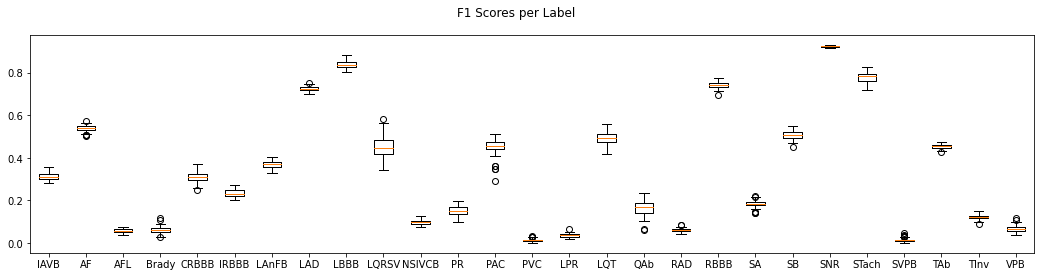

In [99]:
# construct and display the boxplot
x_ticks = []
bp_data = []
for k, v in f1_box_plot_data.items():
    bp_data.append(v)
    x_ticks.append(k)

fig, ax = plt.subplots(figsize=(18, 4))
fig.suptitle("F1 Scores per Label")
ax.boxplot(bp_data)
ax.set_xticklabels(x_ticks)
plt.show()

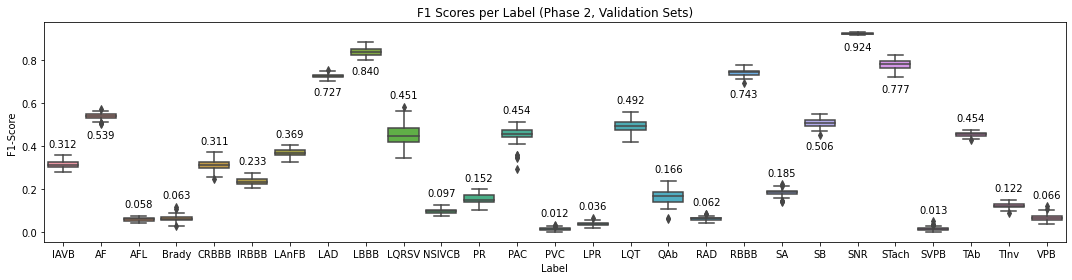

In [100]:
# construct and display the boxplot
box_plot_dict = {"Label": [], "F1-Score": []}
mean_dict = {}
for k, v in f1_box_plot_data.items():
    box_plot_dict["Label"] += [k,] * len(v)
    box_plot_dict["F1-Score"] += v
    mean_dict[k] = np.mean(v)

bp_df = pd.DataFrame(box_plot_dict)
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.boxplot(x="Label", y="F1-Score", data=bp_df, ax=ax)

# print(mean_dict)

for label_idx, xtick in enumerate(ax.get_xticklabels()):
    xtick_name = xtick.get_text()
    val_output = f"{mean_dict[xtick_name]:.3f}"
    y_offset = mean_dict[xtick_name]
    
    if y_offset >= 0.5:
        y_offset = min(f1_box_plot_data[xtick_name]) - 0.03
        va="top"
    else:
        y_offset = max(f1_box_plot_data[xtick_name]) + 0.03
        va="bottom"
    
    ax.annotate(
        val_output,
        xy=(label_idx, mean_dict[xtick_name]),
        xytext=(label_idx, y_offset),
        horizontalalignment="center",
        verticalalignment=va
    )

ax.set_title("F1 Scores per Label (Phase 2, Validation Sets)")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "label_f1s.png"), bbox_inches="tight", dpi=300)
plt.show()

# Feature Importance Per Label

For each label, roughly what are the most important features?

In [101]:

feat_importance_data = {}

for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        
        feat_importance_data[abbrv] = feat_importance_data.get(abbrv, []) + [model.feature_importances_]


paper_models/finalized_model_1596697134.sav results...
paper_models/finalized_model_1596703703.sav results...


KeyboardInterrupt: 

In [ ]:
# average all of the importances for all classifiers and all labels?
all_importances = []
for label, v in feat_importance_data.items():
    ft_data = np.stack(v)
    all_importances.append(ft_data)

importances = np.concatenate(all_importances, axis=0)

print("importances.shape", importances.shape)
mean_importances = np.mean(importances, axis=0)

all_importances_rank = importances.argsort(axis=1)
importances_reciprocal_rank = 1 / (all_importances_rank + 1)
rank_importances = np.mean(importances_reciprocal_rank, axis=0)


import json
importance_data = {}
importance_data["rank_importances"] = dict(zip(header[1:], rank_importances.tolist()))
importance_data["rank_sorted_keys"] = sorted(importance_data["rank_importances"].keys(), key=lambda x:importance_data["rank_importances"][x], reverse=True)
importance_data["mean_importances"] = dict(zip(header[1:], mean_importances.tolist()))
importance_data["sorted_keys"] = sorted(importance_data["mean_importances"].keys(), key=lambda x:importance_data["mean_importances"][x], reverse=True)

with open(os.path.join(output_folder, "importances_rank.json"), "w") as f:
    json.dump(importance_data, f)


In [ ]:
for k, v in feat_importance_data.items():    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Feature Importances for {k}")

    ft_data = np.stack(v)
    
    ft_df = pd.DataFrame(data=ft_data, columns=header[1:])

    meds = ft_df.median()
    meds.sort_values(ascending=True, inplace=True)
    
    meds = meds.tail(20)
    
    ft_df = ft_df[meds.index]
        
    result = ft_df.boxplot(vert=False, ax=ax, return_type="dict")

    for line in result["medians"]:
        x, y = line.get_xydata()[1] # top of the median line
        ax.text(x, y, "%.2E" % x, fontsize=9, horizontalalignment="left", verticalalignment="top")
    
    ax.set_xscale("log")
    
    plt.show()
    
    #ax.boxplot(ft_data, labels=to_features, vert=False)
    #ax.set_xticklabels(x_ticks)
    
    #plt.show()
    #print(np.stack(v, axis=1).shape)    

## Feature Importances

Visualize the feature importances in a figure by lead and feature type (heart rate variability, template, full waveform)?

In [ ]:
lead_feat_type_counter = {}

for k, v in importance_data["mean_importances"].items():
    lead_type, *feat_args = k.split("__")
#     print(lead_type)
    lead, *feat_type = lead_type.split("_")
    
    if lead == "age":
        continue
    
    if "hb" in feat_type:
        # heart beat feat type
        feat_type = "Heartbeat\nTemplate"
    elif "sig" in feat_type:
        # full waveform feat type
        feat_type = "Full\nWaveform"
    else:
        # heart rate variability type
        feat_type = "Heart Rate\nVariability"
    
    count_dict = lead_feat_type_counter.get(feat_type, {})
    count = count_dict.get(lead, 0)
    count += 1
    count_dict[lead] = count
    lead_feat_type_counter[feat_type] = count_dict

lead_feat_type_df = pd.DataFrame(lead_feat_type_counter)
lead_feat_type_df = lead_feat_type_df.reindex(["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"])
lead_feat_type_df = lead_feat_type_df.reindex(["Full\nWaveform", "Heartbeat\nTemplate", "Heart Rate\nVariability"], axis=1)
lead_feat_type_df

In [ ]:
ax = sns.heatmap(
    lead_feat_type_df,
    annot=True,
    linewidths= 0.2,
    robust=True
)
ax.set_title("Categorized Top 1000 Classification Features")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "top_features.png"), bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
bar_lead_feat_type = {
    "Lead": [],
    "Metric": [],
    "Count": []
}
for lead, count in lead_feat_type_counter["Heart Rate\nVariability"].items():
    bar_lead_feat_type["Lead"].append(lead)
    bar_lead_feat_type["Metric"].append("Heart Rate Variability")
    bar_lead_feat_type["Count"].append(count)
for lead, count in lead_feat_type_counter["Heartbeat\nTemplate"].items():
    bar_lead_feat_type["Lead"].append(lead)
    bar_lead_feat_type["Metric"].append("Heartbeat Template")
    bar_lead_feat_type["Count"].append(count)
for lead, count in lead_feat_type_counter["Full\nWaveform"].items():
    bar_lead_feat_type["Lead"].append(lead)
    bar_lead_feat_type["Metric"].append("Full Waveform")
    bar_lead_feat_type["Count"].append(count)

bar_lead_feat_type_df = pd.DataFrame(bar_lead_feat_type)
bar_lead_feat_type_df

In [ ]:
ax = sns.barplot(
    x="Lead",
    y="Count",
    data=bar_lead_feat_type_df,
    hue="Metric",
    order=["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"],
    hue_order=["Full Waveform", "Heartbeat Template", "Heart Rate Variability"]
)
ax.set_title("Categorized Top 1000 Classification Features")
# plt.tight_layout()

# plt.savefig(os.path.join(output_folder, "top_features.png"), bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
ax = lead_feat_type_df.plot.bar(stacked=True, figsize=(8,4))
ax.set_title("Categorized Top 1000 Classification Features")

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
           color="black")
#     ax.text(x+width/2, 
#             y+height/2, 
#             '{:.0f}'.format(height), 
#             horizontalalignment='center', 
#             verticalalignment='center',
#            color="white")
ax.set_ylabel("Count")
ax.set_xlabel("Lead")

handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)
handles.reverse()
labels.reverse()
ax.legend(handles, labels)

plt.savefig(os.path.join(output_folder, "top_features_bar.png"), bbox_inches="tight", dpi=300)
plt.show()

# Challenge Evaluation Summary Outputs

In [102]:
mean_dict
dxms = pd.read_csv("evaluation-2020/dx_mapping_scored.csv")
dxms

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [103]:
# quick pearson r stat test
totals = {}
a = []
b = []
for k, v in mean_dict.items():
    if k == "VEB":
        k = "VPB"
    t = dxms[dxms["Abbreviation"] == k]["Total"].to_numpy()[0]
#     ratio = t / 43101
#     print(t, ratio)
    totals[k] = t
    a.append(v)
    b.append(t)

# print(a)
# print(b)
print(sp.stats.pearsonr(a, b))

(0.6016223017156943, 0.000901609579204441)


In [ ]:
print("neg_cor", sp.stats.pearsonr(range(10), range(10, 0, -1)))
print("pos_cor", sp.stats.pearsonr(range(10), range(0,10, 1)))
print("no_cor", sp.stats.pearsonr(range(10), [4, 5,] * 5))


In [ ]:
# for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
#           'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
#     print(f"{model_data[k]:>10.3f}")

    
# print("AUROC | AUPRC | Accuracy | F-measure | Fbeta-measure | Gbeta-measure | Challenge metric")
# print(f"{model_data['auroc']:>5.3f} |"
#       f" {model_data['auprc']:>5.3f} |"
#       f" {model_data['accuracy']:>8.3f} |"
#       f" {model_data['f_measure']:>9.3f} |"
#       f" {model_data['f_beta_measure']:>13.3f} |"
#       f" {model_data['g_beta_measure']:>13.3f} |"
#       f" {model_data['challenge_metric']:>16.3f}")


## MED-ARC Training Times

- on 96 parallel cores, used approximately 220 GiB RAM
- each process requires ~2.3GiB of RAM
- takes roughly ~80 seconds to process one record (at 96 parallel cores, one record can be extracted per second)

- classifier training, takes approximately 60-65GiB (sequential classifier training)
    - experiment with parallel classifier training using separate GPU per label
    - GPU RAM usage relatively low (2900MiB), but 100% GPU utilization

In [ ]:
43101 / 60 / 60

In [ ]:
(43101 /2 * 80) / 60 / 60

In [ ]:
(18950 - 2 - (12 * 53)) / 12 / 2


In [ ]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights